# HMM

## Algorithm

In [1]:
import numpy as np
from scipy.special import gammaln

# Global Parameters
y=np.loadtxt("hw5-2.data",delimiter=", ",dtype= 'int')
ytest=np.loadtxt("hw5-2.test",delimiter=", ",dtype= 'int')
m=3
K=2
t=len(y)
niter=10

# Initialize parameters to optimize
Pi=np.zeros([m,1],dtype=np.float128)+1/m
a=np.zeros([m,m],dtype=np.float128)+1/m
Lambda=np.array([[1, 5],[50,100],[200,300]],dtype=np.float128)+0.
mix=np.zeros([m,K],dtype=np.float128)+1/K

In [2]:
def EM_HMM(Pi,a,Lambda,mix,m,K,t,y,ytest,niter):
    Pi=Pi
    a=a
    Lambda=Lambda
    mix=mix
    l_train=np.zeros([niter],dtype=np.float128)
    l_test=np.zeros([niter])

    for i0 in range(niter):

        ######## Probabilities

        # Compute P(yt|qti=1,ptk=1)
        def YgivenQP_f(y):
            res=np.zeros([t,m,K],dtype=np.float128)
            for i in range(m):
                for k in range(K):
                    res[:,i,k]= -Lambda[i,k]+y*np.log(Lambda[i,k])-\
                    gammaln(y+1)
            return(np.exp(res))
        YgivenQP=YgivenQP_f(y)
        YgivenQP_test=YgivenQP_f(ytest)

        # Compute P(yt|qti=1)
        def YgivenQ_f(YgivenQP):
            res=np.zeros([t,m],dtype=np.float128)
            for i in range(m):
                for k in range(K):
                      res[:,i]=res[:,i]+YgivenQP[:,i,k]*mix[i,k]

            return(res)
        YgivenQ=YgivenQ_f(YgivenQP)
        YgivenQ_test=YgivenQ_f(YgivenQP_test)

        # Compute alpha=P(y1..yt-1,qti=1) 
        def alpha_f(YgivenQ):
            res=np.zeros([t,m],dtype=np.float128)
            res[0,:]=YgivenQ[0,:]*np.transpose(Pi)
            for t1 in range(1,t):
                s=np.zeros([1,m])
                for j in range(m):
                    s=s+res[t1-1,j]*YgivenQ[t1,:]*a[j,:]
                res[t1,:]=s
            return(res)
        alpha=alpha_f(YgivenQ)
        alpha_test=alpha_f(YgivenQ_test)

        # Compute beta=P(yt+1..yT,qti=1) 
        def beta_f(YgivenQ):
            res=np.ones([t,m],dtype=np.float128)
            for t1 in range(t-2,-1,-1):
                for i in range(m):
                    s=0
                    for j in range(m):
                        s=s+res[t1+1,j]*a[i,j]*YgivenQ[t1+1,j]
                    res[t1,i]=s
            return(res)
        beta=beta_f(YgivenQ)
        beta_test=beta_f(YgivenQ_test)

        # Compute p(y)
        def py_f(alpha,beta):
            return(np.sum(alpha*beta,axis=1))
        py=py_f(alpha,beta)
        py_test=py_f(alpha_test,beta_test)
        
        # Compute gamma=P(qti=1|y)
        def gamma():
            res=alpha*beta
            for t1 in range(t):
                res[t1,]=res[t1,]/py[t1]
            return(res)
        gamma=gamma()

        # Compute dzeta
        def dzeta():
            res=np.zeros([t-1,m,m],dtype=np.float128)
            for i in range(m):
                for j in range(m):
                    for t1 in range(t-1):
                        res[t1,i,j]=alpha[t1,i]*YgivenQ[t1+1,j]*\
                        beta[t1+1,j]*a[i,j]/py[t1]
            return(res)
        dzeta=dzeta()


        # Compute P(qti=1,ptj=1|y)
        def QPgivenY():
            res=np.zeros([t,m,K],dtype=np.float128)
            for i in range(m):
                for k in range(K):
                    for t1 in range(t):
                        res[t1,i,k]=YgivenQP[t1,i,k]*mix[i,k]*\
                        gamma[t1,i]/YgivenQ[t1,i]
            return(res)
        QPgivenY=QPgivenY()


        ######## Expectation

        # Compute gamma0
        gamma0 = gamma[0,:]

        # Compute Aij
        def A():
            res=np.zeros([m,m],dtype=np.float128)
            for i in range(m):
                for j in range(m):
                    res[i,j]=np.sum(dzeta[:,i,j])
            return(res)
        A=A()

        # Compute Bik
        def B():
            res=np.zeros([m,K],dtype=np.float128)
            for i in range(m):
                for k in range(K):
                    res[i,k]=np.sum(QPgivenY[:,i,k]*y)
            return(res)
        B=B()


        # Compute Cik
        def C():
            res=np.zeros([m,K],dtype=np.float128)
            for i in range(m):
                for k in range(K):
                    res[i,k]=np.sum(QPgivenY[:,i,k])
            return(res)
        C=C()

        ######## Maximization
        # Update a
        def a():
            a=A
            for i in range(m):
                a[i,:]=a[i,:]/np.sum(a[i,:])
            return(a)
        a=a()

        # Update lambda
        Lambda=B/C

        # Update mix
        def mix():
            mix=C
            for i in range(m):
                mix[i,:]=mix[i,:]/np.sum(mix[i,:])
            return(mix)
        mix=mix()

        # Compute the expected likelihood
        def likelihood_train():
            res=np.sum(np.log(Pi)*gamma0)+np.sum(A*np.log(a))+\
            np.sum(B*(np.log(Lambda/np.exp(1))))-np.sum(gammaln(y+1))
            return(res)

        # Compute the train log-likelihood
        l_train[i0]=np.log(py[t-1])
        
        # Compute the test log-likelihood
        l_test[i0]=np.log(py_test[t-1])
    return(A,B,C,Lambda,mix,a,l_train,l_test)
    
EM_HMM=EM_HMM(Pi,a,Lambda,mix,m,K,t,y,ytest,niter)

##Results

In [3]:
# Lambda
EM_HMM[3]

array([[ 1.0357935,  15.862358],
       [ 40.502892,  106.05553],
       [ 188.80634,  272.43183]], dtype=float128)

In [4]:
# mix
EM_HMM[4]

array([[ 0.84402282,  0.15597718],
       [ 0.24993662,  0.75006338],
       [ 0.45000642,  0.54999358]], dtype=float128)

In [5]:
# a
EM_HMM[5]

array([[ 0.19245884,  0.73062408,  0.076917078],
       [ 0.17383237,  0.08696938,  0.73919825],
       [ 0.79999533,  0.15000475,  0.049999924]], dtype=float128)

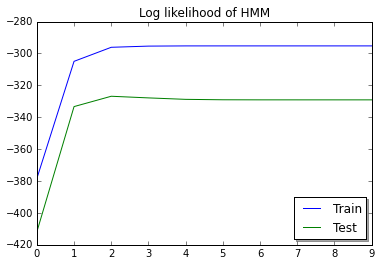

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(10), EM_HMM[6], '-', label='Train')
ax.plot(range(10), EM_HMM[7], '-', label='Test')
plt.title('Log likelihood of HMM')
ax.legend(loc='lower right', shadow=True)
plt.show()

# Mixture model

## Algorithm

In [7]:
# Global parameters
K=6
p=np.zeros([K],dtype=np.float128)+1/K
lambdas=np.array([1, 5,50,100,200,300],dtype=np.float128)+0.
niter=10

# Density
def dpoisson(x,lmd):
    logd= -lmd+x*np.log(lmd)-gammaln(x+1)
    return(np.exp(logd))

In [8]:
def EM_Mixtuure(lambdas,p,K,t,y,ytest,niter):
    l_train=np.zeros([niter],dtype=np.float128)
    l_test=np.zeros([niter],dtype=np.float128)
    
    for i0 in range(niter):    
        ###### Expectation

        # Compute the joint probability of yt and kth component
        def q(k,t1):
            return(p[k]*dpoisson(y[t1],lambdas[k]))
        def q_test(k,t1):
            return(p[k]*dpoisson(ytest[t1],lambdas[k]))

        # Compute the conditional probability of kth component given yt
        def P(k,t1):
            norm=0
            for ktilde in range(K):
                norm = norm+q(ktilde,t1)
            return(q(k,t1)/norm)


        ###### Maximization

        #Z
        def Z(k):
            res=0
            for t1 in range(t):
                res=res+P(k,t1)
            return(res)

        # Update lambdas
        def update_lambdas():
            for k in range(K):
                res=0
                for t1 in range(t):
                    res=res+P(k,t1)*y[t1]
                lambdas[k]=res/Z(k)
        update_lambdas()

        # Update p
        def update_k():
            for k in range(K):
                p[k]=Z(k)/t
            return(p)
        update_k()


        ###### Log Likelihood

        def loglikelihood(p,q):
            res=0
            for t1 in range(t):
                norm=0
                for ktilde in range(K):
                    norm = norm+q(ktilde,t1)
                res=res+np.log(norm)
            return(res)
        
        l_train[i0]=loglikelihood(p,q)
        l_test[i0]=loglikelihood(p,q_test)
        
    return(lambdas,p,l_train,l_test)

EM_Mixtuure=EM_Mixtuure(lambdas,p,K,t,y,ytest,niter)

## Results

In [9]:
# lambdas
EM_Mixtuure[0]

array([ 1.035924,  15.882874,  40.497836,  106.05555,  188.80653,
        272.43183], dtype=float128)

In [10]:
# mixture components p
EM_Mixtuure[1]

array([ 0.31352911,  0.057954703,  0.085659048,  0.25714275,  0.12857314,
        0.15714125], dtype=float128)

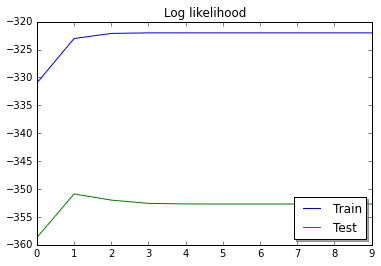

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(10), EM_Mixtuure[2], '-', label='Train')
ax.plot(range(10), EM_Mixtuure[3], '-', label='Test')
plt.title('Log likelihood')
ax.legend(loc='lower right', shadow=True)
plt.show()

# Comparison between HMM and Mixture

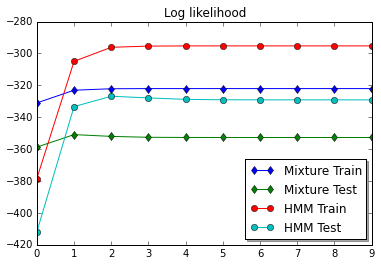

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(10), EM_Mixtuure[2], '-d', label='Mixture Train')
ax.plot(range(10), EM_Mixtuure[3], '-d', label='Mixture Test')
ax.plot(range(10), EM_HMM[6], '-o', label='HMM Train')
ax.plot(range(10), EM_HMM[7], '-o', label='HMM Test')
plt.title('Log likelihood')
ax.legend(loc='lower right', shadow=True)
plt.show()

# Trees

## Algoritm

In [13]:
import numpy as np

# Global Parameters
y=np.loadtxt("hw5-4.data",delimiter=", ")
t=len(y)
mu0=0
mu1=2
v0=1
v1=1
a=0.5 # alpha in the problem set
alphaX1=np.array([0.5,0.5],dtype=np.float128)
niter=10

In [14]:
def Tree_EM(mu0,mu1,v0,v1,a,alphaX1,y,niter):
    l_train=np.zeros([niter],dtype=np.float128)
    
    for i0 in range(niter):
        
        ###### Expectation

        # Compute P(Yt|X=i)
        def YgivenX():
            res=np.zeros([t,2],dtype=np.float128)
            for t1 in range(t):
                res[t1,0]=np.exp(-(y[t1]-mu0)**2/(2*v0))/np.sqrt(2*np.pi*v0)
                res[t1,1]=np.exp(-(y[t1]-mu1)**2/(2*v1))/np.sqrt(2*np.pi*v1)
            return(res)
        YgivenX=YgivenX()

        # Compute P(X2i|Xi) or P(X2i+1|Xi)
        def SgivenX():
            return(np.array([[1-a,a],[a,1-a]],dtype=np.float128))
        SgivenX=SgivenX() 
        
        # Compute beta(xi)
        def beta_f():
            res=np.zeros([t,2],dtype=np.float128)
            res2=np.zeros([t,2],dtype=np.float128)
            maxchild=np.zeros([np.power(2,7)-1,2,2],dtype=np.float128)
            # Fill leaves with normal distributions
            for t1 in range(np.power(2,7),np.power(2,8)):
                res[t1-1,:]=YgivenX[t1-1,:]
                res2[t1-1,:]=YgivenX[t1-1,:]
            # i begins at one like real nodes indices
            for i in range(np.power(2,7)-1,0,-1):
                for j1 in range(2):
                    for j2 in range(2):
                        # Maxchild
                        up0=res2[2*i-1,j1]*res2[(2*i+1)-1,j2]*YgivenX[i-1,0]*\
                        SgivenX[j1,0]*SgivenX[j2,0]
                        up1=res2[2*i-1,j1]*res2[(2*i+1)-1,j2]*YgivenX[i-1,1]*\
                        SgivenX[j1,1]*SgivenX[j2,1]
                        if res2[i-1,0] < up0:
                            res2[i-1,0]=up0
                            maxchild[i-1,0,:]=[j1,j2]
                        if res2[i-1,1]<up1:
                            res2[i-1,1]=up1
                            maxchild[i-1,1,:]=[j1,j2]
                        # Beta
                        res[i-1,0]=res[i-1,0]+res[2*i-1,j1]*res[(2*i+1)-1,j2]*\
                        YgivenX[i-1,0]*SgivenX[j1,0]*SgivenX[j2,0]         
                        res[i-1,1]=res[i-1,1]+res[2*i-1,j1]*res[(2*i+1)-1,j2]*\
                        YgivenX[i-1,1]*SgivenX[j1,1]*SgivenX[j2,1]
            return(res,maxchild)
        
        beta_f=beta_f()
        beta=beta_f[0]
        maxchild=beta_f[1]

        # Compute P(yD2i+1|xi)
        def DgivenX():
            res=np.zeros([np.power(2,7)-1,2],dtype=np.float128)
            for i in range(1,np.power(2,7)):
                for j in range(2):
                    res[i-1,0]=res[i-1,0]+beta[(2*i+1)-1,j]*SgivenX[j,0]
                    res[i-1,1]=res[i-1,1]+beta[(2*i+1)-1,j]*SgivenX[j,1]
            return(res)
        DgivenX=DgivenX()

        # Compute P(yD2i|xi)
        def GgivenX():
            res=np.zeros([np.power(2,7)-1,2],dtype=np.float128)
            for i in range(1,np.power(2,7)):
                for j in range(2):
                    res[i-1,0]=res[i-1,0]+beta[2*i-1,j]*SgivenX[j,0]
                    res[i-1,1]=res[i-1,1]+beta[2*i-1,j]*SgivenX[j,1]
            return(res)
        GgivenX=GgivenX()

        # Compute alpha(xi)
        def alpha():
            res=np.zeros([t,2],dtype=np.float128)
            # Initialze alpha(x1)
            res[0,0]=alphaX1[0]
            res[0,1]=alphaX1[1]
            # i begins at one like real nodes indices
            for i in range(1,np.power(2,7)):
                for j in range(2):
                    res[2*i-1,0]=res[2*i-1,0]+res[i-1,j]*\
                    YgivenX[i-1,j]*DgivenX[i-1,j]*SgivenX[0,j]
                    res[2*i-1,1]=res[2*i-1,1]+res[i-1,j]*\
                    YgivenX[i-1,j]*DgivenX[i-1,j]*SgivenX[1,j]
                    res[(2*i+1)-1,0]=res[(2*i+1)-1,0]+res[i-1,j]*\
                    YgivenX[i-1,j]*GgivenX[i-1,j]*SgivenX[0,j]
                    res[(2*i+1)-1,1]=res[(2*i+1)-1,1]+res[i-1,j]*\
                    YgivenX[i-1,j]*GgivenX[i-1,j]*SgivenX[1,j]
            return(res)
        alpha=alpha()

        # Compute p(y)
        def py():
            return(np.sum(alpha*beta,axis=1))
        py=py()

        # Compute p(xi|y)
        def XgivenY():
            res=alpha*beta
            for i in range(t):
                res[i,:]=res[i,:]/py[i]
            return(res)
        XgivenY=XgivenY()

        # Compute p(xi,x2i|y) or p(xi,x2i+1|y)
        def XSgivenY():
            res=np.zeros([np.power(2,7)-1,2,2],dtype=np.float128)
            for t1 in range(1,np.power(2,7)):
                for j in range(2):
                    for xi in range(2):
                        for xj in range(2):
                            res[t1-1,xi,xj]=res[t1-1,xi,xj]+alpha[t1-1,xi]*\
                            beta[2*t1-1,xj]*beta[(2*t1+1)-1,j]*\
                            YgivenX[t1-1,xi]*SgivenX[xj,xi]*SgivenX[j,xi]
            return(res/py[0])
        XSgivenY=XSgivenY()

        ###### Maximization

        # Update a
        def newa():
            res_diff=0
            for i in range(1,np.power(2,7)):
                res_diff=res_diff+2*(XSgivenY[i-1,0,1]+XSgivenY[i-1,1,0])
            return(res_diff/(t-1))
        a=newa()
        
        # Update sigma0^2
        def newv0():
            num=0
            den=0
            for i in range(t):
                den=den+XgivenY[i,0]
                num=num+XgivenY[i,0]*np.power(y[i]-mu0,2)
            return(num/den)
        v0=newv0()

        # Update sigma1^2
        def newv1():
            num=0
            den=0
            for i in range(t):
                den=den+XgivenY[i,1]
                num=num+XgivenY[i,1]*np.power(y[i]-mu1,2)
            return(num/den)
        v1=newv1()
        
        # Update mu0
        def newmu0():
            num=0
            den=0
            for i in range(t):
                num=num+y[i]*XgivenY[i,0]
                den=den+XgivenY[i,0]
            return(num/den)
        mu0=newmu0()

        # Update mu1
        def newmu1():
            num=0
            den=0
            for i in range(t):
                num=num+y[i]*XgivenY[i,1]
                den=den+XgivenY[i,1]
            return(num/den)
        mu1=newmu1()
        

        ###### Log-likelihood
        l_train[i0]=np.log(py[0])

    return(mu0,mu1,v0,v1,a,l_train,maxchild)

Tree_EM=Tree_EM(mu0,mu1,v0,v1,a,alphaX1,y,niter)

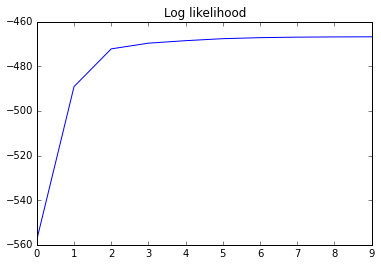

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(Tree_EM[5])
plt.title('Log likelihood')
plt.show()

In [16]:
#mu0
Tree_EM[0]

-0.99501356955284888094

In [17]:
#mu1
Tree_EM[1]

2.1592947568198361604

In [18]:
#v0
Tree_EM[2]

0.62216359423016470031

In [19]:
#v1
Tree_EM[3]

1.5632186874985169451

In [20]:
#a
Tree_EM[4]

0.13863891645807134905

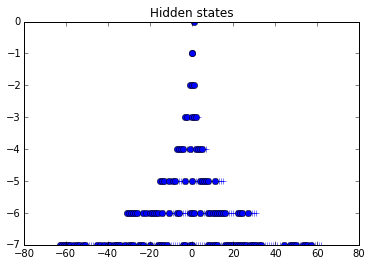

In [21]:
###### Most likely hidden states

%matplotlib inline
# Maxchild
mchild=Tree_EM[6]
# init plot
xaxis=np.zeros([t],dtype=np.int32)
yaxis=np.zeros([t],dtype=np.int32)
for i in range(1,t):
    xaxis[i-1]=(i-3*np.power(2,np.int(np.log2(i))-1)+.5)
    yaxis[i-1]=-np.int(np.log2(i))
    
#labels
def labels():
    res=np.ones([t],dtype=np.int32)
    for i in range(1,np.power(2,7)):
        res[2*i-1]=mchild[i-1,res[i-1],0]
        res[(2*i+1)-1]=mchild[i-1,res[i-1],1]
    return(res)
labels=(labels()==1)

# plot
plt.plot(xaxis,yaxis,'+')
plt.plot(xaxis[labels],yaxis[labels],'bo')
plt.title('Hidden states')
plt.show()